# <strong> Dependencies </strong>

In [1]:
#Matplotlib for making pretty pictures
%matplotlib notebook
from matplotlib import style
#style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [2]:
# Numpy and Pandas for analyzing the data
import numpy as np
import pandas as pd

In [3]:
# Datetime for working with, well, dates and times
import datetime as dt

In [4]:
# Python SQL toolkit to work with the database and Object Relational Mapper (ORM)
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# <strong>Reflect Tables into SQLalchemy ORM 

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflecting the existing databse into a new model
Base = automap_base()

# Reflecting the tables
Base.prepare(engine, reflect = True)

In [7]:
# Viewing classes found by the automap
Base.classes.keys()

['measurement', 'station']

In [8]:
# Creating references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Creating a session between Python and the SQL database ("Hawaii.sql")
session = Session(engine)

# Precipitation Analysis

In [10]:
# Getting a better feel of the data by finding the oldest/earliest and newest/most recent entries
# Oldest date
oldest = session.query(Measurement.date).order_by(Measurement.date).first()
print("The oldest date in the Hawaai.sql database is: {}".format(oldest))


The oldest date in the Hawaai.sql database is: ('2010-01-01',)


In [11]:
# Newest date
newest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("The most recent entry in the Hawaii.sql database is: {}".format(newest))

The most recent entry in the Hawaii.sql database is: ('2017-08-23',)


In [12]:
# Retrieving the last 12 months of precipitation data
year_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-24').\
    order_by(Measurement.date).all()

# Ensuring it works:
#year_precipitation

# Placing the query list into a dataframe
year_precipitation_df = pd.DataFrame(data = year_precipitation)
prcp = year_precipitation_df["prcp"]
prcp.interpolate()
year_precipitation_df["date"] = year_precipitation_df["date"].astype("datetime64[ns]")
year_precipitation_df = year_precipitation_df.dropna()
year_precipitation_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15


<IPython.core.display.Javascript object>


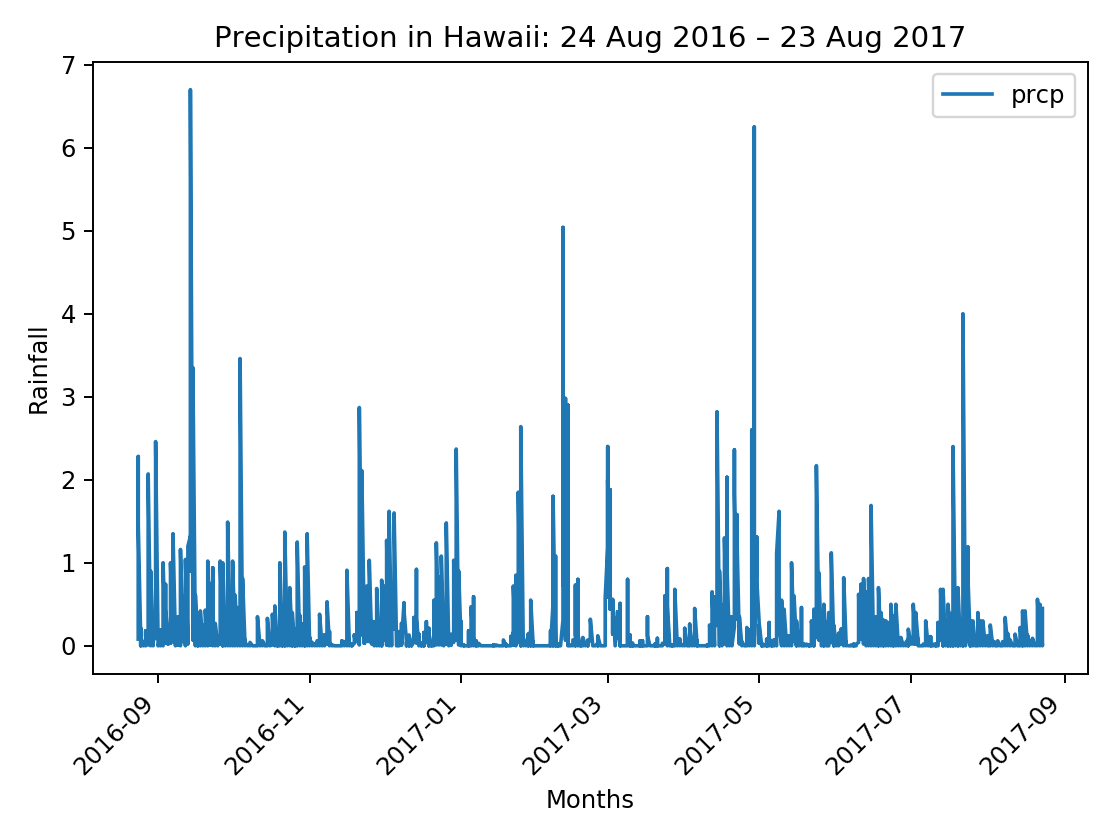

<function matplotlib.pyplot.show(*args, **kw)>

In [18]:
# Plotting the dataframe into a 
year_precipitation_df.plot("date", "prcp")
plt.title("Precipitation in Hawaii: 24 Aug 2016 – 23 Aug 2017")
plt.xlabel("Months")
plt.ylabel("Rainfall")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show

In [19]:
# Summarizing the stats for the precipitation dataframe

year_precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [20]:
# Listing the number of weather stations in this dataset
number_of_stations = session.query(func.count(Station.station)).all()
print("There are {} stations.".format(number_of_stations))

There are [(9,)] stations.


In [21]:
# Disovering which station has the most recorded observations 
obs_by_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
print("Number of recorded obvervations at each Hawaii weather station: ")
obs_by_station

Number of recorded obvervations at each Hawaii weather station: 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Placing the info from obs_by_station into a dataframe
station_ID = [i[0] for i in obs_by_station]
number_of_readings = [i[1] for i in obs_by_station]

station_readings = pd.DataFrame({
    "Station_ID": station_ID,
    "Number_of_Readings": number_of_readings
})


station_readings

,Station_ID,Number_of_Readings
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [50]:
# Pulling out the busiest station
busiest_station = station_ID[0]
print("Station {} is the busiest weather station in our set with  observed readings.".format(busiest_station))

Station USC00519281 is the busiest weather station in our set with  observed readings.


In [49]:
# Getting the most recent 12 months of data
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [53]:
# Creating a DF of busiest station's temps over most recent year
year_temps = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest_station).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

year_temps_df = pd.DataFrame(data = year_temps)

year_temps_df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


<IPython.core.display.Javascript object>


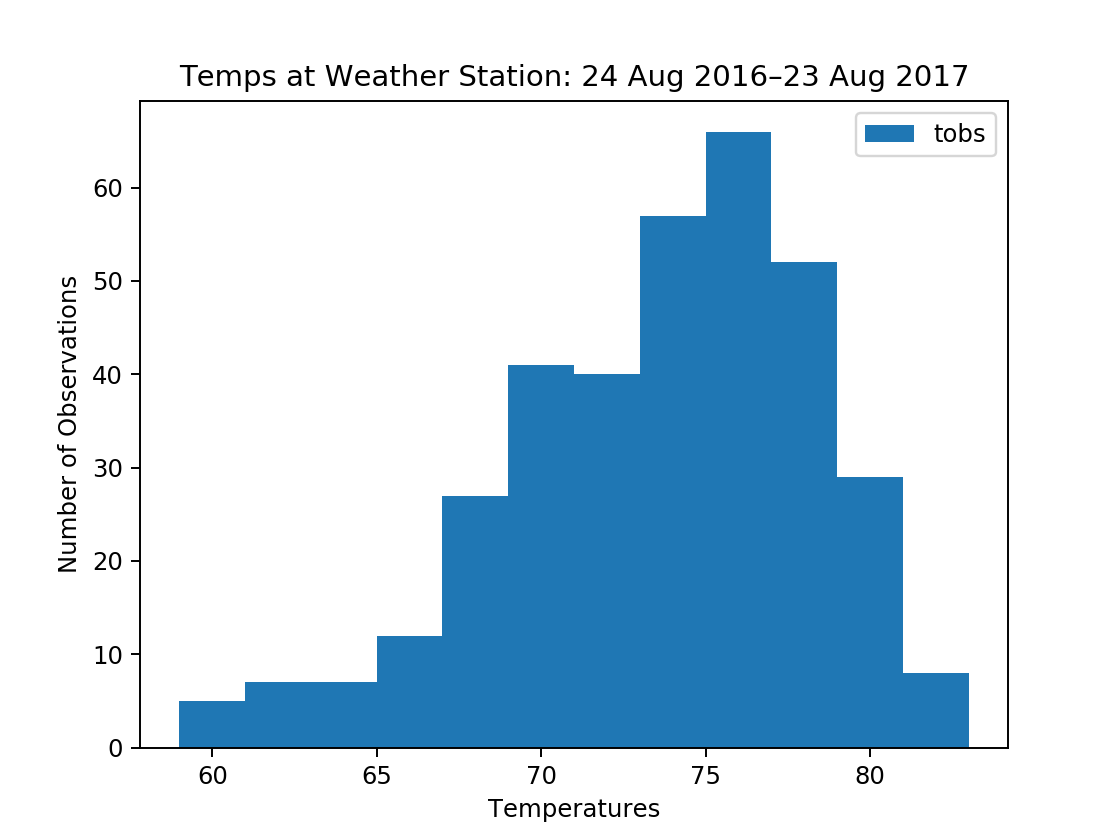

In [66]:
# Plot the temperature results from the busiest staion as a histogram
year_temps_df.plot.hist(x = "date", y = "tobs", bins = 12)
plt.title("Temps at Weather Station: 24 Aug 2016–23 Aug 2017")
plt.xlabel("Temperatures")
plt.ylabel("Number of Observations")
plt.show()

# Temperature Analysis

In [57]:
# Creating a function for analyzing temperatures during our annual Hawaii vacation

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date(string): A date string in the format %Y-%M-%D
        end_date(string): Again, a date string in the format of %Y-%M-%D
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print("Here's the low, high, and avg temps for our 2016 trip: {}".format(calc_temps("2016-12-20", "2016-12-28")))

Here's the low, high, and avg temps for 2016 trip: [(68.0, 78.0, 72.84482758620689)]


In [61]:
# Hmmm, what was the weather like on our 2015 trip (same month/day)?
# Calculating a time delta of 1 year
arrive_2016 = dt.date(2016, 12, 20)
depart_2016 = dt.date(2016, 12, 28)
trip_2015 = dt.timedelta(days = 365)
temps_2015 = (calc_temps((arrive_2016 - trip_2015), (depart_2016 - trip_2015)))

print("Here's the low, high, and avg temps for our 2015 trip: {}".format(temps_2015))

Here's the low, high, and avg temps for our 2015 trip: [(67.0, 79.0, 73.5)]


<IPython.core.display.Javascript object>


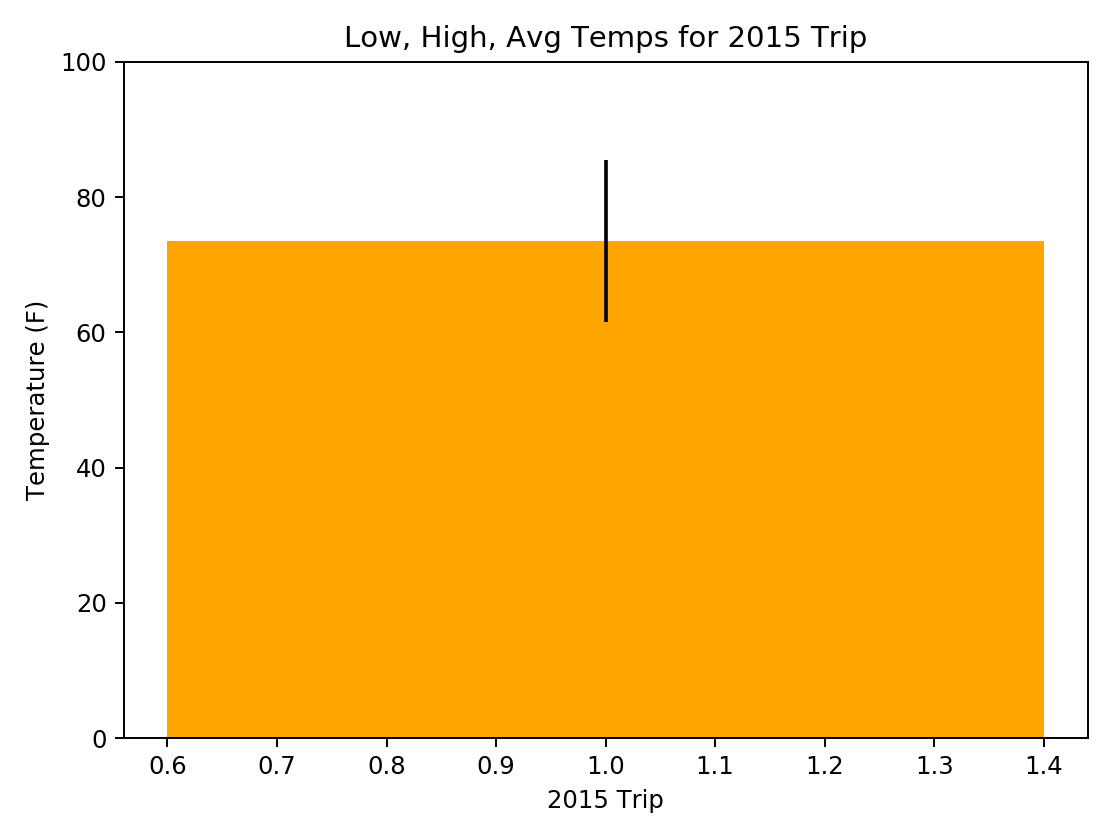

In [92]:
# Plotting vacation 2015 temperatures

avg_temp_2015 = temps_2015[0][2]
peak_to_peak_2015 = temps_2015[0][1] - temps_2015[0][0]

fig, ax = plt.subplots()
bar_chart = ax.bar(1, avg_temp_2015, color = "orange", yerr = peak_to_peak_2015)
x = range(len(temps_2015))
ax.set_title("Low, High, Avg Temps for 2015 Trip")

ax.set_xlabel("2015 Trip")
ax.set_ylabel("Temperature (F)")
plt.ylim(0, 100)
fig.tight_layout()
plt.show()
fig.tight_layout()
plt.show() 